# Регуляризация нейронных сетей

Имя, Фамилия:

---

В этом задании вам необходимо будет реализовать 2 подхода к регуляризации нейронных сетей через ограничения структуры:

*   Dropout
*   Batch normalization

После нужно будет понаблюдать, как они влияют на качество построенной нейронной сети на датасете **CIFAR-10** (Canadian Institute For Advanced Research).

CIFAR-10 состоит из 60k цветных изображений размером 32x32, разделенных на 10 классов, по 6k изображений на каждый класс (train - 50k, test - 10k).

*Подробнее про данные можно посмотреть [тут](https://www.cs.toronto.edu/~kriz/cifar.html)*





In [ ]:
import torchvision.transforms as transforms
from torchvision.datasets import CIFAR10
from torch.utils.data import DataLoader
from torchvision.utils import make_grid

import numpy as np
import matplotlib.pyplot as plt

from tqdm.auto import trange

BATCH_SIZE = 64

Загрузим данные и посмотрим на них:

In [ ]:
transform = transforms.Compose(
    [transforms.Grayscale(num_output_channels=1),
     transforms.ToTensor()])

trainset = CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)

testset = CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = DataLoader(testset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

100%|██████████| 170M/170M [00:03<00:00, 52.8MB/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


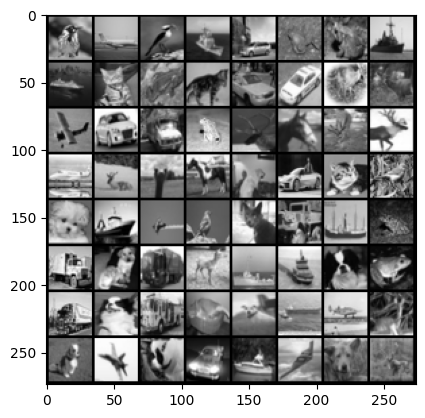

In [ ]:
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

dataiter = iter(trainloader)
images, labels = next(dataiter)

imshow(make_grid(images))

Переиспользуем классы из предыдущего занятия *с минорными изменениями*

In [ ]:
class Module:
    """
    Базовый класс для построения модулей нейронной сети.

    Этот класс предоставляет интерфейс для создания и использования модулей,
    составляющих нейронную сеть.  Он определяет основные методы, которые должны
    быть реализованы в каждом конкретном модуле.

    Attributes:
        mode (str): Режим работы модуля ('train' или 'test').
            Устанавливается с помощью метода set_mode. По умолчанию 'train'.

    Notes:
        Этот класс является абстрактным и не должен использоваться напрямую.
        Он предназначен для создания конкретных модулей нейронной сети, которые
        наследуются от него и реализуют необходимые методы.
    """

    def __init__(self):
        self.mode = 'train'

    def set_mode(self, mode: str) -> None:
        """
        Устанавливает режим работы модуля.

        Args:
            mode (str): Режим работы модуля ('train' или 'test').
        """

        assert mode in ['train', 'test']
        self.mode = mode

    def forward(self, x: np.ndarray) -> np.ndarray:
        """
        Метод для прямого прохода

        Args:
            x (np.ndarray): Входные данные. Размерность может быть (batch_size,
              in_features) или (in_features,) для вектора.

        Returns:
            np.ndarray: Выходные данные после линейного преобразования
            (размерность: (batch_size, out_features) или (out_features,) для вектора).
        """
        pass

    def backward(self, gradient: np.ndarray) -> np.ndarray:
        """
        Метод для обратного прохода

        Args:
            gradient (np.ndarray): Градиент ошибки, полученный от следующего слоя.
            Размерность может быть (batch_size, out_features) или (out_features,)
            для вектора.

        Returns:
            np.ndarray: Градиент ошибки для предыдущего слоя
            (размерность: (batch_size, in_features) или (in_features,) для вектора).
        """
        pass

    def update(self, learning_rate: float) -> None:
        """
        Метод для обновления параметров модуля

        Args:
            learning_rate (float): Скорость обучения.
        """
        pass

In [ ]:
class Linear(Module):
    """
    Реализует полносвязный линейный слой.

    Этот слой выполняет линейное преобразование входных данных: y = xW + b,
    где W - матрица весов, b - вектор смещения, а x - входные данные.

    Args:
        in_features (int): Количество входных признаков.
        out_features (int): Количество выходных признаков.

    Attributes:
        bias (np.ndarray): Параметр сдвига (размер `out_features`).
        weight (np.ndarray): Параметры слоя (размер (`in_features`, `out_features`)).

    """

    def __init__(self, in_features: int, out_features: int):
        super().__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.bias = np.zeros(out_features)
        self.weight = np.random.randn(in_features, out_features)
        self.dW = np.zeros_like(self.weight)
        self.db = np.zeros_like(self.bias)

    def forward(self, x: np.ndarray) -> np.ndarray:
        self.input = x
        return x @ self.weight + self.bias

    def backward(self, gradient: np.ndarray) -> np.ndarray:
        self.dW[:] = self.input.T @ gradient
        self.db[:] = gradient.sum(axis=0)
        return gradient @ self.weight.T

    def update(self, learning_rate: float) -> None:
        self.weight -= learning_rate * self.dW
        self.bias -= learning_rate * self.db

In [ ]:
class ReLU(Module):
    """
    Реализация функции активации ReLU.

    ReLU применяет поэлементную операцию к входным данным,
    заменяя все отрицательные значения на ноль.
    """

    def __init__(self):
        super().__init__()

    def forward(self, x: np.ndarray) -> np.ndarray:
        self.input = x
        return np.maximum(0, x)

    def backward(self, gradient: np.ndarray) -> np.ndarray:
        return gradient * (self.input > 0)

# Задание 1: обучение полносвязной сети (1 балл)

Обучите полносвязную нейронную сеть на заданных данных и протестируйте ее на тестовом датасете

In [ ]:
class Net:
    """
    Реализация нейронной сети с использованием модульной структуры.

    Attributes:
        modules (list[Module]): Список модулей, составляющих сеть.
        learning_rate (float):  Скорость обучения, используемая при обновлении параметров модулей.
        max_iter (int): Максимальное количество эпох обучения.
    """

    def __init__(self,
                 modules: list[Module],
                 learning_rate: float = 0.001,
                 max_iter: int = 10):

        self.modules = modules
        self.learning_rate = learning_rate
        self.max_iter = max_iter

    def __set_mode(self, mode: str):
        """
        Устанавливает режим работы для каждого модуля в сети.

        Args:
            mode (str): Режим работы для каждого модуля ('train' или 'test').
        """

        for i in range(len(self.modules)):
            self.modules[i].set_mode(mode)

    def train(self, trainloader: DataLoader) -> None:
        """
        Обучает модель на заданных данных.

        Args:
            trainloader (DataLoader): Загрузчик данных,
            предоставляющий батчи обучающих данных.
        """

        self.__set_mode('train')

        for epoch in range(self.max_iter):
            total_loss = 0

            for inputs, targets in trainloader:
                inputs, targets = inputs.numpy().reshape(inputs.shape[0], -1), np.array(targets)
                output = inputs

                for module in self.modules:
                    output = module.forward(output)

                exp_scores = np.exp(output - np.max(output, axis=1, keepdims=True))
                probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)
                loss = -np.sum(np.log(probs[np.arange(len(targets)), targets])) / len(targets)
                total_loss += loss
                grads = probs
                grads[np.arange(len(targets)), targets] -= 1
                grads /= len(targets)

                for module in reversed(self.modules):
                    grads = module.backward(grads)

                for module in self.modules:
                    module.update(self.learning_rate)

            print(f"Epoch {epoch+1}/{self.max_iter}, Loss: {total_loss / len(trainloader)}")


    def predict(self, X: np.ndarray) -> np.ndarray:
        """
        Делает предсказание на заданных входных данных.

        Args:
            X (np.ndarray): Матрица входных данных.

        Returns:
            np.ndarray: Матрица предсказанных значений.
        """
        self.__set_mode('test')

        output = X
        for module in self.modules:
            output = module.forward(output)

        return output


Функция для тестирования

In [ ]:
def calculate_accuracy(model: Net, dataloader: DataLoader) -> float:
  """
  Вычисляет точность модели на заданном даталоадере.

  Args:
    model (Net): Модель для тестирования.
    dataloader (DataLoader): Загрузчик данных, предоставляющий батчи тестовых данных.

  Returns:
    float: Accuarcy.
  """
  correct = 0
  total = 0

  for data in dataloader:
    inputs, labels = data
    inputs = inputs.numpy()
    inputs = inputs.reshape(inputs.shape[0], -1)

    outputs = model.predict(inputs)
    predicted = np.argmax(outputs, axis=1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()

  return correct / total

In [ ]:
model = Net([Linear(32 * 32, 128), ReLU(), Linear(128, 10)], learning_rate=0.01, max_iter=10)
model.train(trainloader)

# Проверка на тестовых данных
test_images, test_labels = next(iter(testloader))
test_images = test_images.numpy().reshape(test_images.shape[0], -1)
preds = model.predict(test_images)

accuracy = calculate_accuracy(model, testloader)
print(f"Test Accuracy: {accuracy * 100:.2f}%")


Epoch 1/10, Loss: 25.011916130265973
Epoch 2/10, Loss: 5.210674939991885
Epoch 3/10, Loss: 2.7900214937051806
Epoch 4/10, Loss: 2.4807246688703892
Epoch 5/10, Loss: 2.3676719826227792
Epoch 6/10, Loss: 2.3047039154630546
Epoch 7/10, Loss: 2.263560402785044
Epoch 8/10, Loss: 2.2342921358113297
Epoch 9/10, Loss: 2.2112598605318174
Epoch 10/10, Loss: 2.1946097299136276
Test Accuracy: 21.29%


# Задание 2: Dropout (2 балла)

Реализуйте слой Dropout.

In [ ]:
class Dropout(Module):
    """
    Реализует слой Dropout для регуляризации нейронной сети.

    Dropout случайным образом обнуляет нейроны входного слоя во время обучения,
    чтобы предотвратить переобучение.  Во время тестирования, слой Dropout
    не влияет на входные данные, просто пропуская их без изменений.

    Args:
        p (float): Вероятность того, что нейрон будет обнулен.
                   Значение должно быть между 0 и 1. По умолчанию 0.1.
    """

    def __init__(self, p: float = 0.1):
        super().__init__()
        self.p = p
        self.mask = None

    def forward(self, x: np.ndarray) -> np.ndarray:

      if self.mode == 'train':
          self.mask = np.random.binomial(1, 1 - self.p, size=x.shape)
          return x * self.mask / (1 - self.p)

      elif self.mode == 'test':
          return x

      else:
          raise ValueError(f'Invalid mode: {self.mode}')


    def backward(self, gradient: np.ndarray) -> np.ndarray:
        if self.mode == 'train':
            return gradient * self.mask / (1 - self.p)
        else:
            return gradient

# Задание 3: Batch Normalization (4 балла)

Реализуйте слой Batch Normalization для одномерного случая.

Формулы для обратного прохода можно найти в оригинальной [статье](https://arxiv.org/abs/1502.03167).

*Подсказка:* вот [разбор](https://kratzert.github.io/2016/02/12/understanding-the-gradient-flow-through-the-batch-normalization-layer.html) того, как работает метод обратного распространения ошибки в слое batch normalization.


In [ ]:
class BatchNorm1d(Module):
    """
    Реализует слой Batch Normalization для 1D данных.

    Batch Normalization нормализует активации каждого батча данных,
    чтобы ускорить обучение и улучшить обобщающую способность модели.

    Во время обучения вычисляются среднее и дисперсия для каждого мини-пакета,
    которые используются для нормализации.  Кроме того, вычисляются скользящие
    средние этих статистик для использования во время инференса.

    Args:
        in_features (int): Количество входных признаков.
        eps (float): Небольшое значение, добавленное к дисперсии для
                     предотвращения деления на ноль. По умолчанию 1e-5.
        lamda (float): Фактор затухания для вычисления скользящих средних
                      среднего и дисперсии. По умолчанию 0.9.

    Attributes:
        eps (float): Небольшое значение для предотвращения деления на ноль.
        lamda (float): Фактор затухания для скользящих средних.

        gamma (np.ndarray): Масштабируемый параметр (размер `in_features`).
        beta (np.ndarray): Параметр сдвига (размер `in_features`).

        running_mean (np.ndarray): Скользящее среднее среднего (размер `in_features`).
        running_var (np.ndarray): Скользящее среднее дисперсии (размер `in_features`).
    """

    def __init__(self, in_features: int, eps: float = 1e-5, lamda: float = 0.9):
        super().__init__()
        self.eps = eps
        self.lamda = lamda

        self.gamma = np.random.randn(in_features)
        self.beta = np.zeros(in_features)

        self.running_mean = np.zeros(in_features)
        self.running_var = np.zeros(in_features)

        self.dgamma = np.zeros_like(self.gamma)
        self.dbeta = np.zeros_like(self.beta)


    def forward(self, x: np.ndarray) -> np.ndarray:
        if self.mode == 'train':
            batch_mean = np.mean(x, axis=0)
            batch_var = np.var(x, axis=0)
            self.x_hat = (x - batch_mean) / np.sqrt(batch_var + self.eps)
            self.running_mean = self.lamda * self.running_mean + (1 - self.lamda) * batch_mean
            self.running_var = self.lamda * self.running_var + (1 - self.lamda) * batch_var
            self.x = x
            self.batch_mean = batch_mean
            self.batch_var = batch_var

        elif self.mode == 'test':
            self.x_hat = (x - self.running_mean) / np.sqrt(self.running_var + self.eps)

        else:
            raise ValueError(f'Invalid mode: {self.mode}')

        return self.gamma * self.x_hat + self.beta


    def backward(self, gradient: np.ndarray) -> np.ndarray:
        m = gradient.shape[0]
        self.dgamma = np.sum(gradient * self.x_hat, axis=0)
        self.dbeta = np.sum(gradient, axis=0)
        dx_hat = gradient * self.gamma
        dvar = np.sum(dx_hat * (self.x - self.batch_mean) * -0.5 * (self.batch_var + self.eps) ** (-1.5), axis=0)
        dmean = np.sum(dx_hat * -1 / np.sqrt(self.batch_var + self.eps), axis=0) + dvar * np.mean(-2 * (self.x - self.batch_mean), axis=0)
        dx = dx_hat / np.sqrt(self.batch_var + self.eps) + dvar * 2 * (self.x - self.batch_mean) / m + dmean / m

        return dx


    def update(self, learning_rate: float) -> None:
        self.gamma -= learning_rate * self.dgamma
        self.beta -= learning_rate * self.dbeta

# Задание 4: Обучение полносвязной сети с регуляризацией (3 балла)

Обучите полносвязную нейронную сеть на заданных данных с использованием слоев Dropout и Batch normalization, реализованных в предыдущих заданиях. Протестируйте полученную модель на тестовом датасете.

In [ ]:
model = Net([Linear(32 * 32, 128), BatchNorm1d(128), ReLU(), Dropout(0.2), Linear(128, 10)], learning_rate=0.01, max_iter=10)
model.train(trainloader)
test_images, test_labels = next(iter(testloader))
test_images = test_images.numpy().reshape(test_images.shape[0], -1)
preds = model.predict(test_images)

accuracy = calculate_accuracy(model, testloader)
print(f"Test Accuracy: {accuracy * 100:.2f}%")

Epoch 1/10, Loss: 4.994465449228005
Epoch 2/10, Loss: 2.518119333840815
Epoch 3/10, Loss: 2.2776637909723054
Epoch 4/10, Loss: 2.2320193747282646
Epoch 5/10, Loss: 2.2154276758288973
Epoch 6/10, Loss: 2.2094562349570075
Epoch 7/10, Loss: 2.2017193469099525
Epoch 8/10, Loss: 2.194516854415695
Epoch 9/10, Loss: 2.1878454784514703
Epoch 10/10, Loss: 2.184326900803024
Test Accuracy: 21.72%


In [ ]:
model = Net([
    Linear(32 * 32 * 1, 512), BatchNorm1d(512), ReLU(), Dropout(0.1),
    Linear(512, 256), BatchNorm1d(256), ReLU(), Dropout(0.1),
    Linear(256, 10)
], learning_rate=0.01, max_iter=10)

model.train(trainloader)
test_images, test_labels = next(iter(testloader))
test_images = test_images.numpy().reshape(test_images.shape[0], -1)
preds = model.predict(test_images)

accuracy = calculate_accuracy(model, testloader)
print(f"Test Accuracy: {accuracy * 100:.2f}%")

Epoch 1/10, Loss: 8.668813130075357
Epoch 2/10, Loss: 4.167012204065889
Epoch 3/10, Loss: 2.7833212383891746
Epoch 4/10, Loss: 2.3617764243790442
Epoch 5/10, Loss: 2.2324406859480375
Epoch 6/10, Loss: 2.181216805283679
Epoch 7/10, Loss: 2.159993743557376
Epoch 8/10, Loss: 2.1397124575433444
Epoch 9/10, Loss: 2.1331620868312893
Epoch 10/10, Loss: 2.122272111770593
Test Accuracy: 25.27%


# Домашнее задание № 3

Выполните задания в этом ноутбуке, а также продемонстируйте влияние регуляризации на построенную модель. Напишите полученные выводы.

ВАЖНО: PyTorch можно использовать только для работы с данными.

+ Мягкий дедлайн: `12.02.25 23:59`
+ Жесткий дедлайн: `19.02.25 23:59` (половина баллов)


После жесткого дедлайна задание не принимается.

Test Accuracy полносвязной нейронной сети без Dropout и Batch Normalization (lr = 0.01) - 21.29%.

При добавлении Dropout и Batch Normalization (lr = 0.01) точность увеличилась до 21.72%.

При усложнии структуры нейронной сети (добалвением нескольких слоёв Dropout и Batch Normalization) + (lr = 0.005) точность выросла до 24%. При той же архитектуре, но lr=0.01 - точность 25.27%.

В ячейке ниже проведем эксперимент с различными параметрами.

In [ ]:
import numpy as np
from itertools import product

def run_experiment(hidden_sizes, learning_rates, dropouts, num_epochs, trainloader, testloader):
    results = []

    for h_size, lr, dropout, epochs in product(hidden_sizes, learning_rates, dropouts, num_epochs):
        print(f"Testing: hidden_size={h_size}, lr={lr}, dropout={dropout}, epochs={epochs}")

        model = Net([
            Linear(32 * 32 * 1, h_size), BatchNorm1d(h_size), ReLU(), Dropout(dropout),
            Linear(h_size, h_size // 2), BatchNorm1d(h_size // 2), ReLU(), Dropout(dropout),
            Linear(h_size // 2, 10)
        ], learning_rate=lr, max_iter=epochs)

        model.train(trainloader)
        accuracy = calculate_accuracy(model, testloader)

        results.append({
            'hidden_size': h_size,
            'learning_rate': lr,
            'dropout': dropout,
            'epochs': epochs,
            'test_accuracy': accuracy
        })
        print(f"Test Accuracy: {accuracy:.4f}\n")

    return results

hidden_sizes = [256, 512, 1024]
learning_rates = [0.001, 0.01]
dropouts = [0.0, 0.1, 0.2]
num_epochs = [5, 10]

experiment_results = run_experiment(hidden_sizes, learning_rates, dropouts, num_epochs, trainloader, testloader)
best_result = max(experiment_results, key=lambda x: x['test_accuracy'])
print("Best configuration:", best_result)

Testing: hidden_size=256, lr=0.001, dropout=0.0, epochs=5
Epoch 1/5, Loss: 8.693398609509627
Epoch 2/5, Loss: 6.496348326815702
Epoch 3/5, Loss: 5.5084509031399564
Epoch 4/5, Loss: 4.8626831688211745
Epoch 5/5, Loss: 4.391139301248382
Test Accuracy: 0.1632

Testing: hidden_size=256, lr=0.001, dropout=0.0, epochs=10
Epoch 1/10, Loss: 8.645675843983
Epoch 2/10, Loss: 6.732003555298068
Epoch 3/10, Loss: 5.752346974430288
Epoch 4/10, Loss: 5.07724576203437
Epoch 5/10, Loss: 4.574845999983122
Epoch 6/10, Loss: 4.187027025043513
Epoch 7/10, Loss: 3.8812072571642084
Epoch 8/10, Loss: 3.6242610871125747
Epoch 9/10, Loss: 3.4054468101641575
Epoch 10/10, Loss: 3.2306218335405483
Test Accuracy: 0.1733

Testing: hidden_size=256, lr=0.001, dropout=0.1, epochs=5
Epoch 1/5, Loss: 9.94358148923525
Epoch 2/5, Loss: 7.8402036922092595
Epoch 3/5, Loss: 6.726851074067683
Epoch 4/5, Loss: 5.900243635839398
Epoch 5/5, Loss: 5.24812819156718
Test Accuracy: 0.1382

Testing: hidden_size=256, lr=0.001, dropout=

Лучший результат показала нейронная сеть с параметрами 'hidden_size': 1024, 'learning_rate': 0.01, 'dropout': 0.0, 'epochs': 10. Test accuracy 27,72%. Очень интересно, что лучший результат у сетки без Dropout. Также эксперименты показали, что уменьшение learning_rate приводит к падению accuracy.